### Abstract

This notebook is intended to showcase how to use the MNL (Multinomial Logistic Regression) model to predict the booking probability for each option within a session.

One can find the sample training and testing data under the `data` folder.

In [1]:
# import the model and all the auxiliary functions
from MNL import *
from MNL_plus import *
from Mint import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import pprint 
pp = pprint.PrettyPrinter(indent=4)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
rcParams['figure.dpi'] = 100
rcParams['savefig.dpi'] = 100

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-bml5pno2 because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:

TRAIN_CONFIG = {
    #'MNL_features': MNL_features,
    
    # when absent, by default, use all the features within the training data
    #'alter_features': MNL_features,
    #'session_features'
    
    # options: BinaryCrossEntropy, MaxLogLikelihood
    #'loss':  'MaxLogLikelihood',
    'loss':  'MaxLogLikelihood',
    
    'expand': False,
    
    'optimizer': 'Adam',  # options:  Adam, RMSprop, SGD, LBFGS.
    # Adam would converge much faster
    # LBFGS is a very memory intensive optimizer (it requires additional param_bytes * (history_size + 1) bytes).
    # If it doesn’t fit in memory try reducing the history size, or use a different algorithm.
    # By default, history_size == 100
    'learning_rate': 0.1, # Applicable to Adam, SGD, and LBFGS
    # The learning_rate parameter seems essential to LBFGS, which converges in two epochs.
    #  So far, learning_rate == 0.1 seems to be ok for LBFGS
    
    #'momentum': 0.9,  # applicable to SGD, RMSprop
    'momentum': 0.01,  # applicable to SGD, RMSprop
    
    # The resulting model seems to be more balanced, i.e. no extreme large/small weights,
    #  although one might not have the most ideal performance, i.e. high top_5_rank etc.
    'weight_decay': 0, # Applicable to Adam, RMSprop and SGD
    
    'epochs': 20,
    'early_stop_min_delta': 1e-4,
    'patience': 5,
    
    'gpu': False,  # luckily, running on GPU is faster than CPU in this case.
    
    # level of logging, 0: no log,  1: print epoch related logs;  2: print session related logs
    'verbose': 1,
    
    # Adding the regularization degredates the performance of model
    #   which might suggests that the model is still underfitting, not overfitting.
    'l1_loss_weight': 0,  # e.g. 0.001 the regularization that would marginalize the weights
    'l2_loss_weight': 0,
    
    # flag indicates whether to save gradients during the training
    'save_gradients': False
}


Num features: 17
{'loss': 'MaxLogLikelihood', 'expand': False, 'optimizer': 'Adam', 'learning_rate': 0.1, 'momentum': 0.01, 'weight_decay': 0, 'epochs': 20, 'early_stop_min_delta': 0.0001, 'patience': 5, 'gpu': False, 'verbose': 1, 'l1_loss_weight': 0, 'l2_loss_weight': 0, 'save_gradients': False, 'MNL_features': ['deptime_inbound_cos2p', 'deptime_inbound_cos4p', 'deptime_inbound_sin2p', 'deptime_inbound_sin4p', 'deptime_outbound_cos2p', 'deptime_outbound_cos4p', 'deptime_outbound_sin2p', 'deptime_outbound_sin4p', 'price_elasticity', 'reco_contains_CX', 'reco_contains_MH', 'reco_contains_OD', 'reco_contains_PG', 'reco_contains_SQ', 'reco_contains_TG', 'reco_contains_VN', 'rescaled_reco_eft']}
epoch: 0  loss: -10.149486144764381 best_loss: 1000000000000000.0
epoch: 1  loss: -9.012134675855348 best_loss: -10.149486144764381
epoch: 2  loss: -12.659475007502628 best_loss: -10.149486144764381
epoch: 3  loss: -12.075658117316259 best_loss: -12.659475007502628
epoch: 4  loss: -13.113415362232

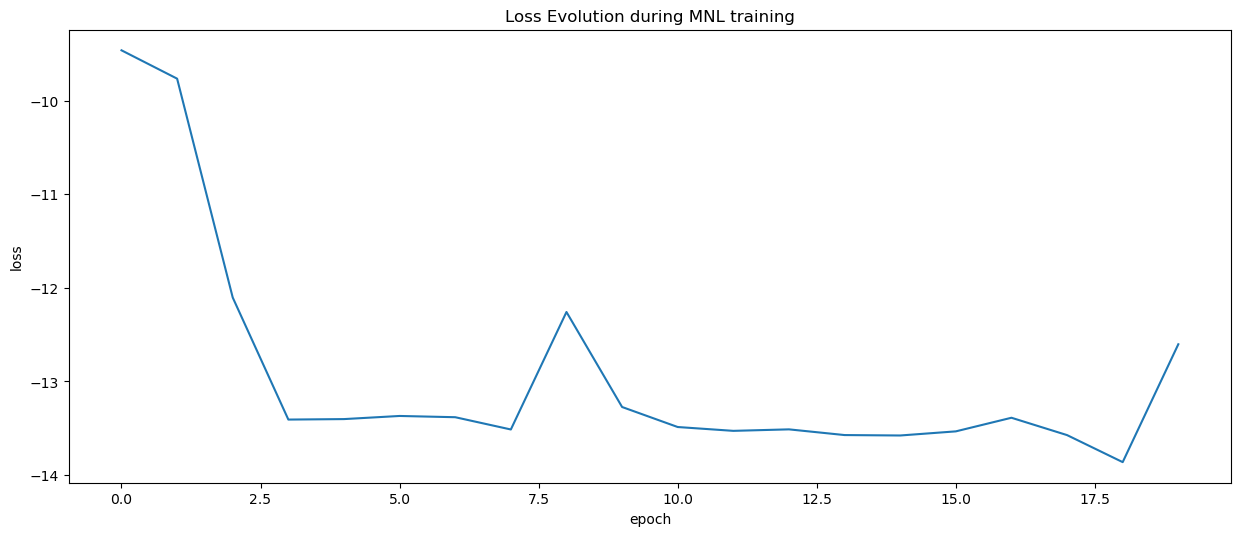

In [4]:
# set random seed for reproduceability
np.random.seed(17)
torch.manual_seed(17)

df_train = pd.read_csv('data/train_SINBKK_RT_B.csv')

# Create a brand-new model
model_tuple, loss_list = run_training(df_training=df_train, train_config=TRAIN_CONFIG)

# Continue training on the existing model
model_tuple, loss_list = run_training(df_training=df_train, train_config=TRAIN_CONFIG, model_tuple=model_tuple)


# unzip the tuple
(model, loss, optimizer) = model_tuple


# plot the evolution of loss
plot_loss(loss_list)

### Model Validation

In this section, we test the trained model and calculate some performance benchmarks.

In [5]:
df_test = pd.read_csv('data/test_SINBKK_RT_B.csv')

test_results = test_model(model, df_test, TRAIN_CONFIG)

test_results.head()

Num of testing sessions: 542


,session_id,alter_id,choice,price_elasticity,rescaled_reco_eft,reco_contains_MH,reco_contains_TG,reco_contains_PG,reco_contains_SQ,reco_contains_VN,...,reco_contains_OD,deptime_outbound_sin2p,deptime_outbound_sin4p,deptime_outbound_cos2p,deptime_outbound_cos4p,deptime_inbound_sin2p,deptime_inbound_sin4p,deptime_inbound_cos2p,deptime_inbound_cos4p,pred_value
12272,1703297276,0,1,435.6,0.000000,0,1,0,0,0,...,0,-0.108867,0.216439,-0.994056,0.976296,-0.906308,-7.660441e-01,4.226180e-01,-0.642788,0.000000e+00
12273,1703297276,1,0,186.8,0.000000,0,0,0,0,0,...,0,-0.402747,0.737277,-0.915312,0.675590,0.043619,-8.715581e-02,-9.990482e-01,0.996195,1.000000e+00
12274,1703297276,2,0,216.6,3.997044,1,0,0,0,0,...,0,-0.806445,0.953717,-0.591309,-0.300706,1.000000,1.224647e-16,6.123234e-17,-1.000000,3.816978e-192
12275,1703297276,3,0,216.6,5.080044,1,0,0,0,0,...,0,-0.806445,0.953717,-0.591309,-0.300706,1.000000,1.224647e-16,6.123234e-17,-1.000000,3.423179e-219
12276,1703297276,4,0,216.6,5.497044,1,0,0,0,0,...,0,-0.806445,0.953717,-0.591309,-0.300706,1.000000,1.224647e-16,6.123234e-17,-1.000000,1.318558e-229


In [6]:
# Test the model with the testing data
# Calculate the probability and the trank of the chosen alternative
test_stats = validate(model, df_test, TRAIN_CONFIG)

test_stats.head()

Num of testing sessions: 542


,session_id,session_size,num_chosen_choices,rank_of_chosen_one,prob_of_chosen_one,max_prob
0,1702036,36,1,26.5,0.000000e+00,1.000000
1,1704193,60,1,40.5,0.000000e+00,0.863301
2,17033132,60,1,2.0,9.560976e-50,1.000000
3,17041139,60,1,1.0,1.000000e+00,1.000000
4,17042962,60,1,2.0,9.558583e-17,1.000000


Summarize the testing results into a list of KPIs, such as:

- *mean_probability*: the average probability of the predicted alternative among all sessions


- *top_5_rank_quantile*: the percentile of sessions where the probability of the predicted alternative is among the top 5.


- *AIC*: Akaike Information Criterion, which offers an estimate of the relative information lost when a given model is used to represent the process that generated the data.

In [7]:
summarize_KPIs(test_stats, len(TRAIN_CONFIG['MNL_features']))

{'session_num': 542,
 'mean_session_size': 54.7029520295203,
 'top_1_rank_quantile': 11.07011070110701,
 'top_5_rank_quantile': 27.121771217712176,
 'top_10_rank_quantile': 36.715867158671585,
 'mean_rank_ratio': 0.4250111235817008,
 'median_rank_ratio': 0.525,
 'mean_rank': 22.631918819188193,
 'median_rank': 21.0,
 'mean_probability': 0.11068156526079526,
 'median_probability': 2.2521259924308626e-232,
 'mean_probability_diff': -0.8822068045790608,
 'median_probability_diff': -0.9999999999999989,
 'log_likelihood': -inf,
 'mean_log_likelihood': -inf,
 'AIC': inf}

### Model Deployment

In this section, we show some examples on how to use the APIs to serialize the model and eventually deploy it in the production environment. 

In [8]:
# Transfer the trained model to a minimized model for later inference.
model_to_deploy = Mint(TRAIN_CONFIG['MNL_features'], model.get_feature_weights())

model_to_deploy.get_feature_weights()

{'deptime_inbound_cos2p': 22.154397502739318,
 'deptime_inbound_cos4p': -21.859528388337626,
 'deptime_inbound_sin2p': -75.5733169290863,
 'deptime_inbound_sin4p': -11.688776986653709,
 'deptime_outbound_cos2p': -34.90392093155359,
 'deptime_outbound_cos4p': 4.613833871600256,
 'deptime_outbound_sin2p': 35.09828912073398,
 'deptime_outbound_sin4p': -29.18238730401567,
 'price_elasticity': -4.091185658157526,
 'reco_contains_CX': -11.082418833949987,
 'reco_contains_MH': -56.243953257247306,
 'reco_contains_OD': -0.7340172793425487,
 'reco_contains_PG': -66.8419821413993,
 'reco_contains_SQ': -2.614931469782748,
 'reco_contains_TG': 78.72566947429883,
 'reco_contains_VN': -6.023405073883778,
 'rescaled_reco_eft': -57.50571262893409}

In [ ]:
get_chosen_pred_value

In [ ]:
model_to_deploy.get_feature_weights()

In [9]:
# Dump/Pickle the model object into a binary file.
model_to_deploy.save('model/mint_model.pkl')

save model to  model/mint_model.pkl


In [10]:
# instantialize a new model from the pickle file
inference_model = load_model('model/mint_model.pkl')

load model from  model/mint_model.pkl


In [11]:
# Sample a session for test
sample_session = df_test[df_test['session_id'] == 170326817]
test_X = sample_session[TRAIN_CONFIG['MNL_features']]
test_X.head()

,deptime_inbound_cos2p,deptime_inbound_cos4p,deptime_inbound_sin2p,deptime_inbound_sin4p,deptime_outbound_cos2p,deptime_outbound_cos4p,deptime_outbound_sin2p,deptime_outbound_sin4p,price_elasticity,reco_contains_CX,reco_contains_MH,reco_contains_OD,reco_contains_PG,reco_contains_SQ,reco_contains_TG,reco_contains_VN,rescaled_reco_eft
1617,0.422618,-0.642788,-0.906308,-0.766044,-0.422618,-0.642788,0.906308,-0.766044,248.6,0,0,0,0,0,1,0,0.0
1618,-0.980785,0.923880,0.195090,-0.382683,-0.994056,0.976296,-0.108867,0.216439,217.6,0,0,0,0,0,1,0,0.0
1619,-0.980785,0.923880,0.195090,-0.382683,-0.518773,-0.461748,-0.854912,0.887011,217.6,0,0,0,0,0,1,0,0.0
1620,-0.980785,0.923880,0.195090,-0.382683,-0.422618,-0.642788,0.906308,-0.766044,233.6,0,0,0,0,0,1,0,0.0
1621,-0.887011,0.573576,-0.461749,0.819152,-0.994056,0.976296,-0.108867,0.216439,233.6,0,0,0,0,0,1,0,0.0


In [12]:
# Compare the results given by the original model with Pytorch and
#   the inference model without pytorch. 

# Note: there are some subtle differences which should be due to the fact
#   that the precision provided by Pytorch and Pandas/Numpy libraries is different.
inference_model.predict(test_X) - model.predict(test_X).reshape(-1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Implementation with expand option 

In this section, I show how to use the expand option. You will see that there are three datasets this time (take a look at the dummy do file in the data folder to see how they are constructed)

In [13]:
TRAIN_CONFIG = {
    #'MNL_features': MNL_features,
    
    # when absent, by default, use all the features within the training data
    #'alter_features': MNL_features,
    #'session_features'
    'alter_features':['reco_contains_mh', 'reco_contains_tg', 'reco_contains_pg', 'reco_contains_sq', 'reco_contains_vn', 'reco_contains_cx', 'reco_contains_od'],
    'session_features':['deptime_outbound_sin2p', 'deptime_outbound_sin4p', 'deptime_outbound_cos2p', 'deptime_outbound_cos4p', 'deptime_inbound_sin2p', 'deptime_inbound_sin4p', 'deptime_inbound_cos2p', 'deptime_inbound_cos4p'],
    'choice_groups':['group','group2'],
    
    # options: BinaryCrossEntropy, MaxLogLikelihood
    #'loss':  'MaxLogLikelihood',
    'loss':  'MaxLogLikelihood',
    
    'expand': True,
    
    'optimizer': 'Adam',  # options:  Adam, RMSprop, SGD, LBFGS.
    # Adam would converge much faster
    # LBFGS is a very memory intensive optimizer (it requires additional param_bytes * (history_size + 1) bytes).
    # If it doesn’t fit in memory try reducing the history size, or use a different algorithm.
    # By default, history_size == 100
    'learning_rate': 0.1, # Applicable to Adam, SGD, and LBFGS
    # The learning_rate parameter seems essential to LBFGS, which converges in two epochs.
    #  So far, learning_rate == 0.1 seems to be ok for LBFGS
    
    #'momentum': 0.9,  # applicable to SGD, RMSprop
    'momentum': 0,  # applicable to SGD, RMSprop
    
    # The resulting model seems to be more balanced, i.e. no extreme large/small weights,
    #  although one might not have the most ideal performance, i.e. high top_5_rank etc.
    'weight_decay': 0.01, # Applicable to Adam, RMSprop and SGD
    
    'epochs': 20,
    'early_stop_min_delta': 1e-4,
    'patience': 5,
    
    'gpu': False,  # luckily, running on GPU is faster than CPU in this case.
    
    # level of logging, 0: no log,  1: print epoch related logs;  2: print session related logs
    'verbose': 1,
    
    # Adding the regularization degredates the performance of model
    #   which might suggests that the model is still underfitting, not overfitting.
    'l1_loss_weight': 0,  # e.g. 0.001 the regularization that would marginalize the weights
    'l2_loss_weight': 0,
    
    # flag indicates whether to save gradients during the training
    'save_gradients': True
}


In [14]:
alter_data = pd.read_csv('data/train_SINBKK_RT_B_alter_id.csv')
session_data = pd.read_csv('data/train_SINBKK_RT_B_session_id.csv')
choices = pd.read_csv('data/train_SINBKK_RT_B_choices.csv')

In [15]:
model_tuple, loss_list = run_training(df_training=choices, train_config=TRAIN_CONFIG, alter_data=alter_data, session_data=session_data)

Num features: 15
{'alter_features': ['reco_contains_mh', 'reco_contains_tg', 'reco_contains_pg', 'reco_contains_sq', 'reco_contains_vn', 'reco_contains_cx', 'reco_contains_od'], 'session_features': ['deptime_outbound_sin2p', 'deptime_outbound_sin4p', 'deptime_outbound_cos2p', 'deptime_outbound_cos4p', 'deptime_inbound_sin2p', 'deptime_inbound_sin4p', 'deptime_inbound_cos2p', 'deptime_inbound_cos4p'], 'choice_groups': ['group', 'group2'], 'loss': 'MaxLogLikelihood', 'expand': True, 'optimizer': 'Adam', 'learning_rate': 0.1, 'momentum': 0, 'weight_decay': 0.01, 'epochs': 20, 'early_stop_min_delta': 0.0001, 'patience': 5, 'gpu': False, 'verbose': 1, 'l1_loss_weight': 0, 'l2_loss_weight': 0, 'save_gradients': True, 'MNL_features': ['deptime_outbound_sin2p', 'deptime_outbound_sin4p', 'deptime_outbound_cos2p', 'deptime_outbound_cos4p', 'deptime_inbound_sin2p', 'deptime_inbound_sin4p', 'deptime_inbound_cos2p', 'deptime_inbound_cos4p', 'reco_contains_mh', 'reco_contains_tg', 'reco_contains_pg'

Num features: 15


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch: 0  loss: -19.763614608874946 best_loss: 1000000000000000.0
epoch: 1  loss: -19.763614608874946 best_loss: -19.763614608874946
epoch: 2  loss: -19.763614608874946 best_loss: -19.763614608874946
epoch: 3  loss: -19.763614608874946 best_loss: -19.763614608874946
epoch: 4  loss: -19.763614608874946 best_loss: -19.763614608874946
epoch: 5  loss: -19.763614608874946 best_loss: -19.763614608874946
Early stopping!  epoch: 5 min_delta: 0.0001  patience: 5
Final epoch: 5  loss: -19.763614608874946


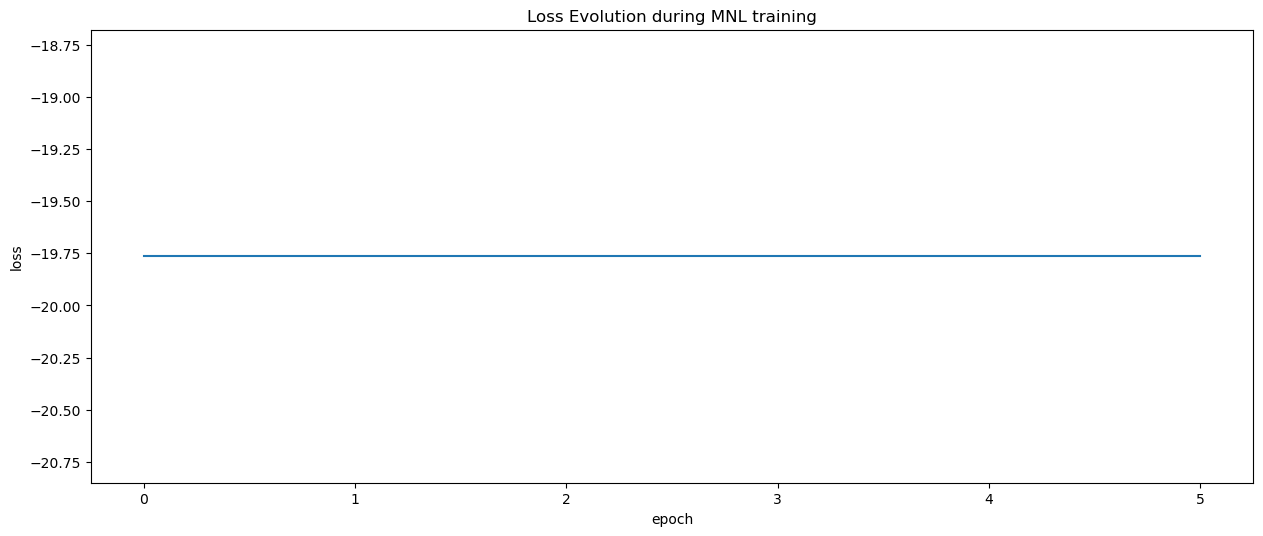

In [16]:
model_tuple, loss_list = run_training(df_training=choices, train_config=TRAIN_CONFIG, alter_data=alter_data, session_data=session_data, model_tuple=model_tuple)

# unzip the tuple
(model, loss, optimizer) = model_tuple

# plot the evolution of loss
plot_loss(loss_list)

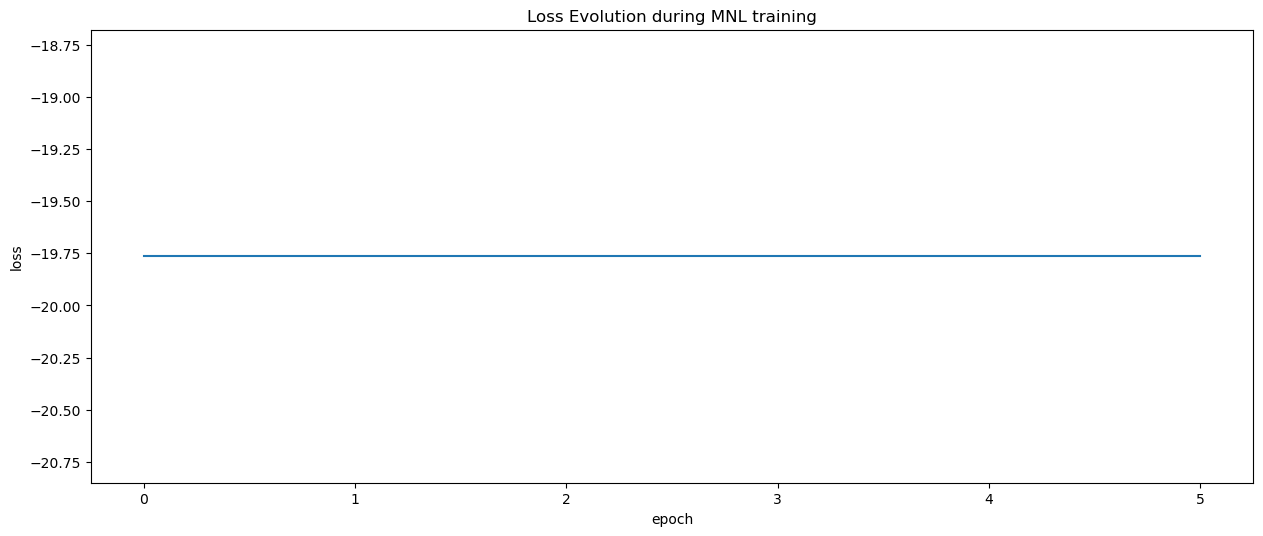

In [18]:
# unzip the tuple
(model, loss, optimizer) = model_tuple


# plot the evolution of loss
plot_loss(loss_list)

In [19]:
predY = model.predict(choices.values, binary=False)



TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, int64, int32, int16, int8, uint8, and bool.

In [ ]:
        predY = model.predict(testing_data.values, binary=False)

        #print('SessionId:', session_id)
        #print('AlterId:', df_session['alter_id'].values)
        #print('Real Y-value:', df_session['choice'].values)
        #print('Prediction:', predY)

        choice_value = df_session['choice'].values